# Next Best Offer модель ML
Идея продукта состоит в анализе юр.информации и динамики финансовой и транзакционной активности клиентов.
На основании паттернов поведения и истории подключения продуктов банка предлагается производить таргетированное предложения подключения новых услуг исходя из текущего состояния клиента. Программа NBO и модель предлагаемая нашей командой состоит в использовании ML для рекомендации наиболее перспективного с точки зрения сделки - продукта, с учетом его времени жизни в банке, его стоимости и привлекаемости для клиента. Привлекаемость клиента на продукт меряется при помощи нашей модели Бустинга классификации, которая выдает для каждого продукта вероятность отклика на него клиентом. Далее предпологается использовать следующую формулу для рекомендации:

#### Ранк рекомендации продукта= Его привлекательность для клиента х Время жизни продукта в среднем в банке х Стоимость продукта для клиента

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
pd.set_option('max_columns',200)
%pylab inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier

Populating the interactive namespace from numpy and matplotlib


with open('data.pickle', 'wb') as f:
    pickle.dump(data, f)

with open('data.pickle', 'rb') as f:
    data_new = pickle.load(f)

# Загрузка данных

In [24]:
# Компания
company = pd.read_csv('data/company.csv', sep=';')

In [25]:
company.head(5)

,ID Компании,Вид Компании,Вид Компании 2,Тип деятельности,Оквед Код,Город обслуживания,Возраст Компании,Маркетинг Ключевой запрос,Маркетинг Канал,Маркетинг Источник1,Маркетинг Источник2,Телефон,E-mail,Анкета Налогообложение,Анкета Сотрудники,Анкета Способ ведения бухгалтерии,Анкета ежемесечный оборот компании,Кол-во счетов в других банках,Холдинг,Налоговая,Кол-во Звонков,Кол-во Дизлайков,Кол-во Лайков,Закрыт,Кол-во операций за все время,Кол-во счетов,Кол-во закрытых счетов,Кол-во активных счетов,Дата первой операции,Дата последней операции,Продукт УСН 6%,Продукт ПДБ,ПродуктВалютный Контроль,Продукт Касса,Продукт Белый Бизнес,Продукт Депозиты,Кол-во сотрудников,Кол-во сообщений,Кол-во активных месяцев,Неактивен,Кол-во связных компаний,Кол. Орг. у Ген. Директора,Количество Бенефициаров,Кол-во платежей з/п,web,ios,android,Кол-во перевод на ФЗ,Кол-во налогов,Кол-во операций по картам,Кол-во карт,Кол-во платежей,Кол-во снятие наличных,Кол-во взноса денежных средств,Оборот за все время Руб,зарплатный фот,Маржа за все время,Маржа средная,Остатки максимальные,Остатки среднии,Исходящий оборот,Перевод ФЗ,Сумма налог,оборот по картам,Сумма взноса денежных средств,Банкомат,Перевод,Уставный капитал,SCOR1,SCOR2,SCOR3,SCOR4,SCOR5,SCOR6,SCOR7,SCOR8,SCOR9,SCOR10,SCOR11,SCOR12
0,1,ЮЛ,NaN,Прочее,NaN,29.0,NaN,0.0,3.0,0.0,NaN,+7926,2378.0,NaN,NaN,NaN,0.0,0,0,NaN,4.0,NaN,NaN,NaN,5.0,1,0,0,-154.0,15.0,0,0,0,0,0,0,NaN,NaN,1,1,NaN,NaN,NaN,0,0,0,0,0,0,NaN,NaN,0,NaN,NaN,0.05512,NaN,0.53232,3.74882,0.08825,0.20781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,ЮЛ,NaN,Прочее,NaN,29.0,NaN,NaN,NaN,NaN,NaN,+7916,2116.0,NaN,NaN,NaN,0.0,0,0,NaN,6.0,NaN,NaN,NaN,162.0,1,1,0,-1758.0,50.0,0,0,0,0,0,0,NaN,NaN,1,1,NaN,0.0,3.0,0,0,0,0,1,0,NaN,NaN,1,NaN,NaN,2.30501,NaN,0.47522,3.34672,0.01106,0.02605,0.02433,0.04010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,ЮЛ,NaN,Прочее,NaN,29.0,NaN,NaN,NaN,NaN,NaN,+7999,631.0,NaN,NaN,NaN,0.0,0,0,NaN,1.0,NaN,NaN,NaN,59.0,5,0,0,-360.0,4.0,0,0,0,0,0,0,NaN,NaN,2,1,NaN,NaN,NaN,0,0,0,0,2,1,NaN,NaN,14,NaN,NaN,2.28152,NaN,1.29334,4.55410,0.90004,1.32748,1.40234,0.39991,0.07008,NaN,NaN,NaN,0.76888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,ЮЛ,NaN,Прочее,NaN,29.0,NaN,0.0,3.0,0.0,NaN,+7926,2378.0,NaN,NaN,NaN,0.0,0,1,NaN,3.0,NaN,NaN,NaN,27.0,1,1,0,-118.0,85.0,0,0,0,0,0,0,NaN,NaN,4,1,NaN,NaN,NaN,0,0,0,0,0,1,NaN,NaN,6,NaN,NaN,0.92425,NaN,5.51867,9.71618,13.19959,26.73567,1.03260,NaN,1.21800,NaN,NaN,NaN,0.05695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,ИП,Индивидуальный предприниматель,ТИ,62.01,25.0,5.0,NaN,3.0,6.0,NaN,+7961,1516.0,УСН 6%,Нет,Веду сам,0.0,1,0,NaN,8.0,0.0,896.0,NaN,1683.0,3,0,2,12.0,799.0,0,1,1,0,0,0,NaN,295.0,27,0,NaN,0.0,0.0,0,357,503,0,43,24,827.0,1.0,392,182.0,5.0,2.42753,NaN,0.33727,0.08797,0.44296,0.24683,2.18148,1.13982,2.01115,3.15999,0.21457,0.02694,0.81160,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
company['Возраст Компании'].min()

0.0

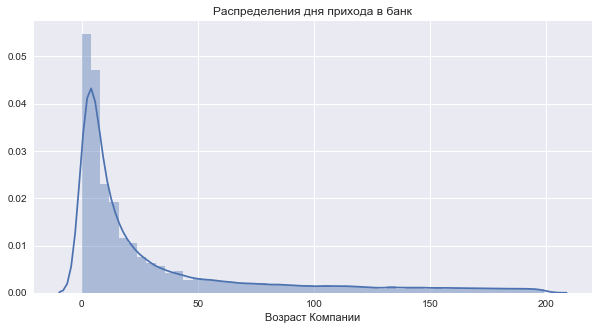

In [27]:
plt.figure(figsize=(10,5))
sns.distplot(company['Возраст Компании'].dropna()[company['Возраст Компании']<200])
plt.title('Распределения дня прихода в банк')

In [28]:
# Продукт
products=pd.read_csv('data/products.csv', sep=';')

In [29]:
# Месяц даты подключения
products['Дата Подключения мес.'] = products['Дата Подключения']//30

In [30]:
products.head()

,ID Компании,Продукт,Закрыт,Дата Подключения,Срок Действия,Дата Подключения мес.
0,38379,Подари другу банк,1,441,27,14
1,38631,Подари другу банк,1,291,30,9
2,38727,Подари другу банк,1,5,40,0
3,38895,Подари другу банк,1,1,47,0
4,38955,Подари другу банк,1,3,34,0


In [31]:
products.groupby('Продукт')['Срок Действия'].median().sort_values(ascending=False).reset_index()

,Продукт,Срок Действия
0,OVERDRAFTS,365.0
1,KRED_CORP,365.0
2,Бесплатный бухгалтер для ИП,268.0
3,Валютный контроль,246.0
4,Бухгалтер для ИП,233.0
5,Абонентская плата со скидкой 15% пакет Оптимал...,183.0
6,Главбух,112.5
7,Бухгалтер для ИП на УСН6%,91.0
8,Белый Бизнес,37.0
9,Подари другу банк,31.0


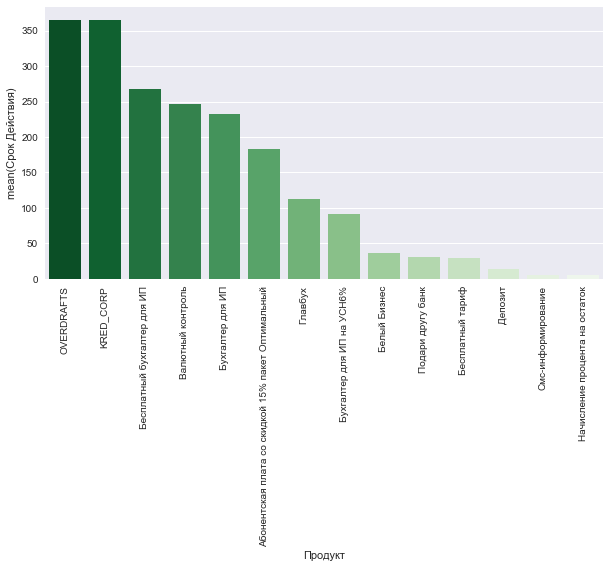

In [32]:
plt.figure(figsize=(10, 5))
plt.xticks(rotation='vertical')
sns.barplot(data=products.groupby('Продукт')['Срок Действия'].median().sort_values(ascending=False).reset_index(),
            y='Срок Действия', x = 'Продукт', palette='Greens_r')

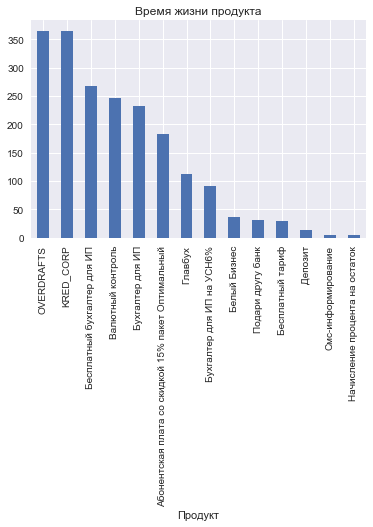

In [33]:
products.groupby('Продукт')['Срок Действия'].median().sort_values(ascending=False).plot(kind='bar')
plt.title('Время жизни продукта')

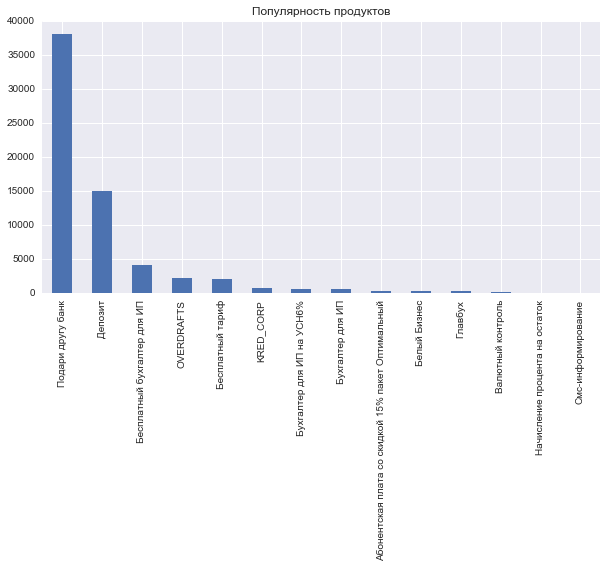

In [34]:
plt.figure(figsize=(10,5))
products['Продукт'].value_counts().plot(kind='bar')
plt.title('Популярность продуктов')

In [35]:
products['Продукт'].value_counts().to_dict()

{'KRED_CORP': 752,
 'OVERDRAFTS': 2229,
 'Абонентская плата со скидкой 15% пакет Оптимальный': 319,
 'Белый Бизнес': 227,
 'Бесплатный бухгалтер для ИП': 4076,
 'Бесплатный тариф': 2016,
 'Бухгалтер для ИП': 557,
 'Бухгалтер для ИП на УСН6%': 625,
 'Валютный контроль': 183,
 'Главбух': 192,
 'Депозит': 14986,
 'Начисление процента на остаток': 21,
 'Подари другу банк': 38059,
 'Смс-информирование': 1}

In [36]:
# Тариф
tarif = pd.read_csv('data/tarifs.csv', sep=';')

In [37]:
tarif.head()

,ID Компании,Название Тарифа,Закрыт,Дата Подключения,Срок действия
0,36919,БЕЗЛИМИТНЫЙ,1,6,101
1,39688,СТАРТОВЫЙ,0,2,479
2,39692,ОПТИМАЛЬНЫЙ,0,6,68
3,39722,СТАРТОВЫЙ,0,238,162
4,39722,ОПТИМАЛЬНЫЙ,1,85,152


In [14]:
# Время жизни тарифа
tarif[tarif['Закрыт']==0].groupby('Название Тарифа')['Срок действия'].median()

Название Тарифа
БЕЗЛИМИТНЫЙ    100
ОПТИМАЛЬНЫЙ    223
СТАРТОВЫЙ      344
Name: Срок действия, dtype: int64

In [15]:
# Сотрудники компании
employers = pd.read_csv('data/employers.csv', sep=';')

In [16]:
employers.head()

,ID Компании,ИНН,Должность,Доля в компании,Управляет,Возраст,Пол
0,5,1,Индивидуальный предприниматель,100.0,1,25.0,1.0
1,6,2,Индивидуальный предприниматель,100.0,1,33.0,1.0
2,7,3,Индивидуальный предприниматель,100.0,1,27.0,1.0
3,8,4,Индивидуальный предприниматель,100.0,1,55.0,2.0
4,8,4,Генеральный директор,0.0,1,55.0,2.0


In [17]:
# Месячный Агрегат по компаниям
month = pd.read_csv('data/month-agg.csv', sep=';')

In [18]:
month.head()

,ID Компании,Пакет действующий на период,Месяц,Открыт/закрыт,Активных месяц,УСН 6%,ПДБ,Клиент ВК,Касса Подключен,Белый Бизнес продукт,Депозиты ЮЛ продукт,Кол-во сообщений,Лайк,Дизлайк,Кол-во платежей з/п,web,ios,android,Кол-во перевод на ФЗ,Кол-во налогов,Кол-во операций по картам,Кол-во карт,Кол-во платежей,Кол-во снятие наличных,Кол-во взноса денежных средств,Маржа,Остатки,Исходящий оборот,Перевод ФЗ,Сумма налог,оборот по картам,Сумма взноса денежных средств,Банкомат,Перевод,Платежи
0,5,ОПТИМАЛЬНЫЙ,2,Открыт,1,0,1,1,0,0,0,NaN,NaN,NaN,0.0,13,3,0,0.0,3.0,27.0,1.0,7.0,8.0,NaN,1.39111,0.05240,0.27017,NaN,0.60643,0.57282,NaN,NaN,NaN,NaN
1,5,ОПТИМАЛЬНЫЙ,17,Открыт,1,0,0,1,0,0,0,5.0,12.0,0.0,0.0,20,21,0,2.0,0.0,22.0,1.0,23.0,12.0,NaN,-2.69975,1.22278,1.78578,3.59734,NaN,1.13819,NaN,2.26637,2.51145,NaN
2,5,ОПТИМАЛЬНЫЙ,19,Открыт,1,0,0,1,0,0,0,15.0,8.0,0.0,0.0,30,23,0,6.0,1.0,7.0,1.0,23.0,4.0,NaN,1.76292,1.29774,1.79935,3.62396,1.08553,0.98304,NaN,NaN,3.04962,NaN
3,5,ОПТИМАЛЬНЫЙ,26,Открыт,1,0,0,1,0,0,0,NaN,NaN,NaN,0.0,1,3,0,0.0,0.0,1.0,1.0,2.0,0.0,NaN,-0.19197,0.25510,0.00759,NaN,NaN,0.02257,NaN,NaN,NaN,NaN
4,5,ОПТИМАЛЬНЫЙ,14,Открыт,1,0,0,1,0,0,0,6.0,18.0,0.0,0.0,11,15,0,2.0,0.0,22.0,1.0,24.0,9.0,NaN,0.69225,1.38022,1.63454,1.23470,NaN,0.85584,NaN,NaN,1.79389,NaN


In [19]:
tarif[tarif['Закрыт']==1]['Срок действия'].mean()/30

5.069788431169537

# Отбор и генерация первичных (абсолютных) признаков для модели

In [20]:
# Отметим те месяцы в месечном агрегате, которые соответствуют изменениям в пакете услуг для конкретной компании
# month - тут месячный агрегат
# products - тут записаны измения в пакете услуг для конкретной компании
feature_data = products.merge(month, left_on=['ID Компании', 'Дата Подключения мес.'],
                              right_on=['ID Компании', 'Месяц']).sort_values(['ID Компании', 'Месяц'])

In [21]:
feature_data.head()

,ID Компании,Продукт,Закрыт,Дата Подключения,Срок Действия,Дата Подключения мес.,Пакет действующий на период,Месяц,Открыт/закрыт,Активных месяц,УСН 6%,ПДБ,Клиент ВК,Касса Подключен,Белый Бизнес продукт,Депозиты ЮЛ продукт,Кол-во сообщений,Лайк,Дизлайк,Кол-во платежей з/п,web,ios,android,Кол-во перевод на ФЗ,Кол-во налогов,Кол-во операций по картам,Кол-во карт,Кол-во платежей,Кол-во снятие наличных,Кол-во взноса денежных средств,Маржа,Остатки,Исходящий оборот,Перевод ФЗ,Сумма налог,оборот по картам,Сумма взноса денежных средств,Банкомат,Перевод,Платежи
22096,5,Подари другу банк,1,9,50,0,ОПТИМАЛЬНЫЙ,0,Открыт,1,0,1,1,0,0,0,48.0,170.0,0.0,0.0,12,63,0,0.0,0.0,11.0,1.0,3.0,10.0,NaN,0.94090,0.35957,0.29665,NaN,NaN,0.88822,NaN,9.06547,NaN,NaN
22094,5,Подари другу банк,1,60,30,2,ОПТИМАЛЬНЫЙ,2,Открыт,1,0,1,1,0,0,0,NaN,NaN,NaN,0.0,13,3,0,0.0,3.0,27.0,1.0,7.0,8.0,NaN,1.39111,0.05240,0.27017,NaN,0.60643,0.57282,NaN,NaN,NaN,NaN
22093,5,Бесплатный бухгалтер для ИП,1,303,227,10,ОПТИМАЛЬНЫЙ,10,Открыт,1,0,0,1,0,0,0,5.0,50.0,0.0,0.0,6,6,0,0.0,0.0,29.0,1.0,6.0,1.0,1.0,0.87394,0.24146,0.24404,NaN,NaN,0.65341,13.36984,NaN,0.35878,NaN
22095,5,Подари другу банк,1,548,29,18,ОПТИМАЛЬНЫЙ,18,Открыт,1,0,1,1,0,0,0,4.0,6.0,0.0,0.0,20,13,0,3.0,0.0,1.0,1.0,9.0,1.0,NaN,2.37547,0.99014,1.16645,2.09381,NaN,0.26873,NaN,NaN,NaN,NaN
22092,5,OVERDRAFTS,0,582,365,19,ОПТИМАЛЬНЫЙ,19,Открыт,1,0,0,1,0,0,0,15.0,8.0,0.0,0.0,30,23,0,6.0,1.0,7.0,1.0,23.0,4.0,NaN,1.76292,1.29774,1.79935,3.62396,1.08553,0.98304,NaN,NaN,3.04962,NaN


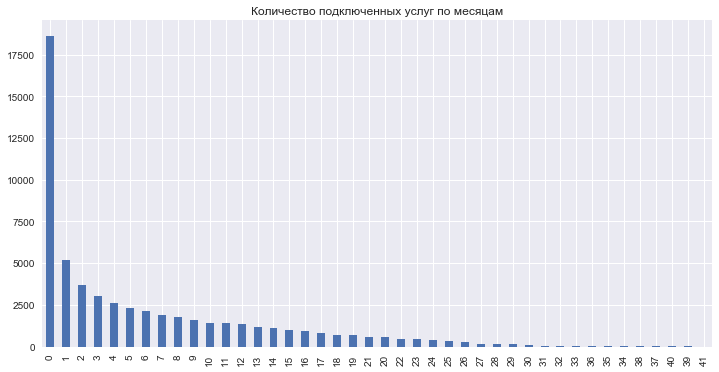

In [22]:
plt.figure(figsize=(12, 6))
feature_data['Месяц'].value_counts().plot(kind='bar')
plt.title('Количество подключенных услуг по месяцам')

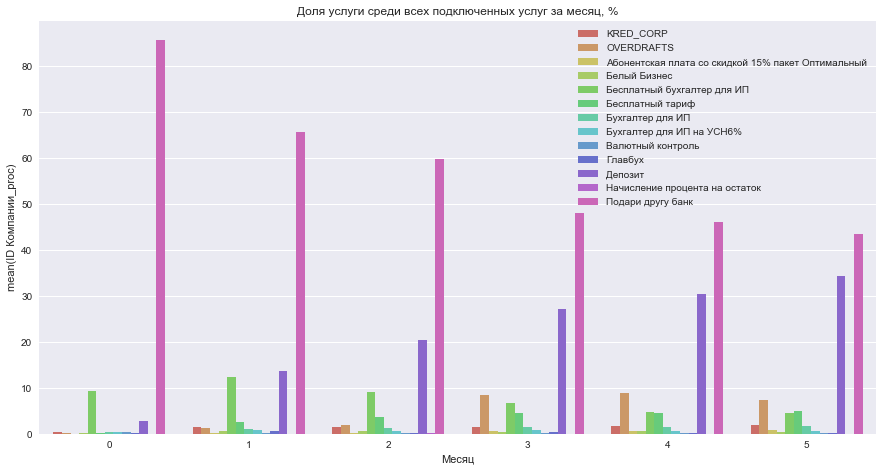

In [27]:
d = feature_data.groupby(['Продукт', 'Месяц'])['ID Компании'].count().reset_index()
d = d.merge(d.groupby('Месяц').sum().reset_index().rename(columns={'ID Компании':'sum_Месяц'}),on='Месяц')
d['ID Компании_proc'] = d['ID Компании']/d['sum_Месяц']*100

plt.figure(figsize=(15, 7.6))
sns.barplot(data=d[d['Месяц']<=5], x='Месяц', y='ID Компании_proc', hue='Продукт', palette=sns.color_palette("hls", 14))
#plt.legend(loc=(1, 0.4))
plt.legend(loc='upper right')
plt.title('Доля услуги среди всех подключенных услуг за месяц, %')

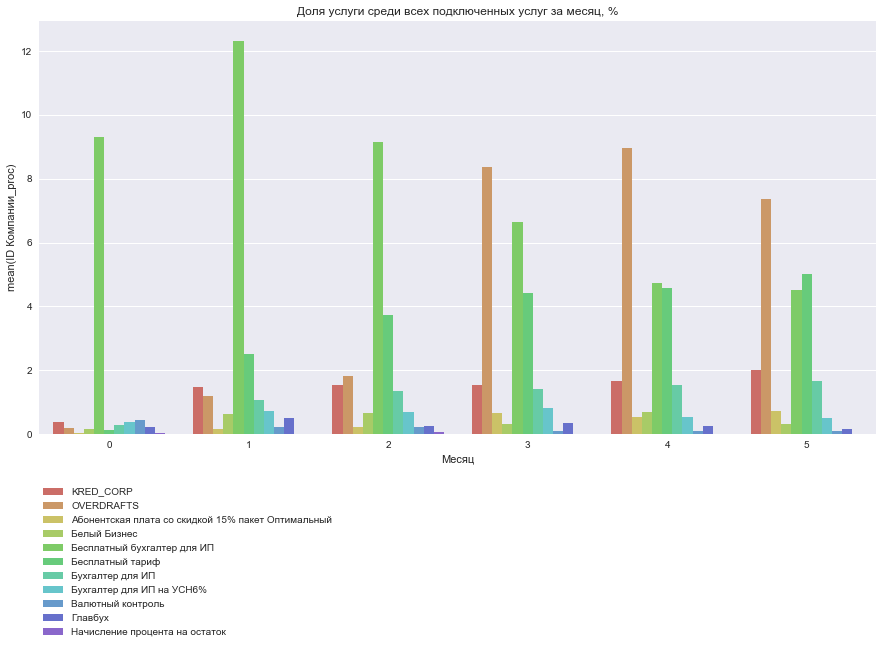

In [35]:
d = feature_data.groupby(['Продукт', 'Месяц'])['ID Компании'].count().reset_index()
d = d.merge(d.groupby('Месяц').sum().reset_index().rename(columns={'ID Компании':'sum_Месяц'}),on='Месяц')
d['ID Компании_proc'] = d['ID Компании']/d['sum_Месяц']*100

plt.figure(figsize=(15, 7.6))
sns.barplot(data=d[(d['Месяц']<=5)&(d['Продукт']!='Подари другу банк')&(d['Продукт']!='Депозит')],
            x='Месяц', y='ID Компании_proc', hue='Продукт', palette=sns.color_palette("hls", 14))
#plt.legend(loc=(1, 0.4))
plt.legend(loc=(0, -0.5))
plt.title('Доля услуги среди всех подключенных услуг за месяц, %')

In [23]:
# Признаки, которые берем из датасета Компании
company_ = company[[   'ID Компании', 'Вид Компании', 'Вид Компании 2', 'Тип деятельности',
                       'Оквед Код', 'Город обслуживания', 'Возраст Компании',
                       'Маркетинг Канал', 'Телефон', 'Анкета Налогообложение',
                       'Анкета Сотрудники', 'Анкета Способ ведения бухгалтерии',
                       'Анкета ежемесечный оборот компании', 'Кол-во счетов в других банках',
                       'Холдинг', 'Кол-во сотрудников', 'Кол. Орг. у Ген. Директора', 'Количество Бенефициаров']]

In [24]:
data = feature_data.merge(company_, how='left', on='ID Компании')

In [25]:
data.head()

,ID Компании,Продукт,Закрыт,Дата Подключения,Срок Действия,Дата Подключения мес.,Пакет действующий на период,Месяц,Открыт/закрыт,Активных месяц,УСН 6%,ПДБ,Клиент ВК,Касса Подключен,Белый Бизнес продукт,Депозиты ЮЛ продукт,Кол-во сообщений,Лайк,Дизлайк,Кол-во платежей з/п,web,ios,android,Кол-во перевод на ФЗ,Кол-во налогов,Кол-во операций по картам,Кол-во карт,Кол-во платежей,Кол-во снятие наличных,Кол-во взноса денежных средств,Маржа,Остатки,Исходящий оборот,Перевод ФЗ,Сумма налог,оборот по картам,Сумма взноса денежных средств,Банкомат,Перевод,Платежи,Вид Компании,Вид Компании 2,Тип деятельности,Оквед Код,Город обслуживания,Возраст Компании,Маркетинг Канал,Телефон,Анкета Налогообложение,Анкета Сотрудники,Анкета Способ ведения бухгалтерии,Анкета ежемесечный оборот компании,Кол-во счетов в других банках,Холдинг,Кол-во сотрудников,Кол. Орг. у Ген. Директора,Количество Бенефициаров
0,5,Подари другу банк,1,9,50,0,ОПТИМАЛЬНЫЙ,0,Открыт,1,0,1,1,0,0,0,48.0,170.0,0.0,0.0,12,63,0,0.0,0.0,11.0,1.0,3.0,10.0,NaN,0.94090,0.35957,0.29665,NaN,NaN,0.88822,NaN,9.06547,NaN,NaN,ИП,Индивидуальный предприниматель,ТИ,62.01,25.0,5.0,3.0,+7961,УСН 6%,Нет,Веду сам,0.0,1,0,NaN,0.0,0.0
1,5,Подари другу банк,1,60,30,2,ОПТИМАЛЬНЫЙ,2,Открыт,1,0,1,1,0,0,0,NaN,NaN,NaN,0.0,13,3,0,0.0,3.0,27.0,1.0,7.0,8.0,NaN,1.39111,0.05240,0.27017,NaN,0.60643,0.57282,NaN,NaN,NaN,NaN,ИП,Индивидуальный предприниматель,ТИ,62.01,25.0,5.0,3.0,+7961,УСН 6%,Нет,Веду сам,0.0,1,0,NaN,0.0,0.0
2,5,Бесплатный бухгалтер для ИП,1,303,227,10,ОПТИМАЛЬНЫЙ,10,Открыт,1,0,0,1,0,0,0,5.0,50.0,0.0,0.0,6,6,0,0.0,0.0,29.0,1.0,6.0,1.0,1.0,0.87394,0.24146,0.24404,NaN,NaN,0.65341,13.36984,NaN,0.35878,NaN,ИП,Индивидуальный предприниматель,ТИ,62.01,25.0,5.0,3.0,+7961,УСН 6%,Нет,Веду сам,0.0,1,0,NaN,0.0,0.0
3,5,Подари другу банк,1,548,29,18,ОПТИМАЛЬНЫЙ,18,Открыт,1,0,1,1,0,0,0,4.0,6.0,0.0,0.0,20,13,0,3.0,0.0,1.0,1.0,9.0,1.0,NaN,2.37547,0.99014,1.16645,2.09381,NaN,0.26873,NaN,NaN,NaN,NaN,ИП,Индивидуальный предприниматель,ТИ,62.01,25.0,5.0,3.0,+7961,УСН 6%,Нет,Веду сам,0.0,1,0,NaN,0.0,0.0
4,5,OVERDRAFTS,0,582,365,19,ОПТИМАЛЬНЫЙ,19,Открыт,1,0,0,1,0,0,0,15.0,8.0,0.0,0.0,30,23,0,6.0,1.0,7.0,1.0,23.0,4.0,NaN,1.76292,1.29774,1.79935,3.62396,1.08553,0.98304,NaN,NaN,3.04962,NaN,ИП,Индивидуальный предприниматель,ТИ,62.01,25.0,5.0,3.0,+7961,УСН 6%,Нет,Веду сам,0.0,1,0,NaN,0.0,0.0


In [26]:
# Преобразуем Оквед Код в нужный формат
def get_list_full(x):
    if pd.isnull(x):
        return [0,0,0]
    else:
        l=[int(i) for i in x.split('.')]
        if len(l)==3:
            return l
        if len(l)==2:
            l.append(0)
            return l
        if len(l)==1:
            return l+[0,0]
        
data['Оквед Код 1']=data['Оквед Код'].map(lambda x: get_list_full(x)[0])
data['Оквед Код 2']=data['Оквед Код'].map(lambda x: get_list_full(x)[1])
data['Оквед Код 3']=data['Оквед Код'].map(lambda x: get_list_full(x)[2])

In [27]:
# Признаки, которые берем из Сотрудники
data=data.merge(employers.groupby('ID Компании')['Возраст'].mean().reset_index(), on='ID Компании', how='left')
data=data.merge(employers.groupby('ID Компании')['Пол'].min().reset_index(), on='ID Компании', how='left')

In [28]:
data.head()

,ID Компании,Продукт,Закрыт,Дата Подключения,Срок Действия,Дата Подключения мес.,Пакет действующий на период,Месяц,Открыт/закрыт,Активных месяц,УСН 6%,ПДБ,Клиент ВК,Касса Подключен,Белый Бизнес продукт,Депозиты ЮЛ продукт,Кол-во сообщений,Лайк,Дизлайк,Кол-во платежей з/п,web,ios,android,Кол-во перевод на ФЗ,Кол-во налогов,Кол-во операций по картам,Кол-во карт,Кол-во платежей,Кол-во снятие наличных,Кол-во взноса денежных средств,Маржа,Остатки,Исходящий оборот,Перевод ФЗ,Сумма налог,оборот по картам,Сумма взноса денежных средств,Банкомат,Перевод,Платежи,Вид Компании,Вид Компании 2,Тип деятельности,Оквед Код,Город обслуживания,Возраст Компании,Маркетинг Канал,Телефон,Анкета Налогообложение,Анкета Сотрудники,Анкета Способ ведения бухгалтерии,Анкета ежемесечный оборот компании,Кол-во счетов в других банках,Холдинг,Кол-во сотрудников,Кол. Орг. у Ген. Директора,Количество Бенефициаров,Оквед Код 1,Оквед Код 2,Оквед Код 3,Возраст,Пол
0,5,Подари другу банк,1,9,50,0,ОПТИМАЛЬНЫЙ,0,Открыт,1,0,1,1,0,0,0,48.0,170.0,0.0,0.0,12,63,0,0.0,0.0,11.0,1.0,3.0,10.0,NaN,0.94090,0.35957,0.29665,NaN,NaN,0.88822,NaN,9.06547,NaN,NaN,ИП,Индивидуальный предприниматель,ТИ,62.01,25.0,5.0,3.0,+7961,УСН 6%,Нет,Веду сам,0.0,1,0,NaN,0.0,0.0,62,1,0,25.0,1.0
1,5,Подари другу банк,1,60,30,2,ОПТИМАЛЬНЫЙ,2,Открыт,1,0,1,1,0,0,0,NaN,NaN,NaN,0.0,13,3,0,0.0,3.0,27.0,1.0,7.0,8.0,NaN,1.39111,0.05240,0.27017,NaN,0.60643,0.57282,NaN,NaN,NaN,NaN,ИП,Индивидуальный предприниматель,ТИ,62.01,25.0,5.0,3.0,+7961,УСН 6%,Нет,Веду сам,0.0,1,0,NaN,0.0,0.0,62,1,0,25.0,1.0
2,5,Бесплатный бухгалтер для ИП,1,303,227,10,ОПТИМАЛЬНЫЙ,10,Открыт,1,0,0,1,0,0,0,5.0,50.0,0.0,0.0,6,6,0,0.0,0.0,29.0,1.0,6.0,1.0,1.0,0.87394,0.24146,0.24404,NaN,NaN,0.65341,13.36984,NaN,0.35878,NaN,ИП,Индивидуальный предприниматель,ТИ,62.01,25.0,5.0,3.0,+7961,УСН 6%,Нет,Веду сам,0.0,1,0,NaN,0.0,0.0,62,1,0,25.0,1.0
3,5,Подари другу банк,1,548,29,18,ОПТИМАЛЬНЫЙ,18,Открыт,1,0,1,1,0,0,0,4.0,6.0,0.0,0.0,20,13,0,3.0,0.0,1.0,1.0,9.0,1.0,NaN,2.37547,0.99014,1.16645,2.09381,NaN,0.26873,NaN,NaN,NaN,NaN,ИП,Индивидуальный предприниматель,ТИ,62.01,25.0,5.0,3.0,+7961,УСН 6%,Нет,Веду сам,0.0,1,0,NaN,0.0,0.0,62,1,0,25.0,1.0
4,5,OVERDRAFTS,0,582,365,19,ОПТИМАЛЬНЫЙ,19,Открыт,1,0,0,1,0,0,0,15.0,8.0,0.0,0.0,30,23,0,6.0,1.0,7.0,1.0,23.0,4.0,NaN,1.76292,1.29774,1.79935,3.62396,1.08553,0.98304,NaN,NaN,3.04962,NaN,ИП,Индивидуальный предприниматель,ТИ,62.01,25.0,5.0,3.0,+7961,УСН 6%,Нет,Веду сам,0.0,1,0,NaN,0.0,0.0,62,1,0,25.0,1.0


**Сформируем месячные срезы для всех компаний, за месяц и за 2 до того момента, как компания взяла какую-либу услугу**

In [29]:
month.head()

,ID Компании,Пакет действующий на период,Месяц,Открыт/закрыт,Активных месяц,УСН 6%,ПДБ,Клиент ВК,Касса Подключен,Белый Бизнес продукт,Депозиты ЮЛ продукт,Кол-во сообщений,Лайк,Дизлайк,Кол-во платежей з/п,web,ios,android,Кол-во перевод на ФЗ,Кол-во налогов,Кол-во операций по картам,Кол-во карт,Кол-во платежей,Кол-во снятие наличных,Кол-во взноса денежных средств,Маржа,Остатки,Исходящий оборот,Перевод ФЗ,Сумма налог,оборот по картам,Сумма взноса денежных средств,Банкомат,Перевод,Платежи
0,5,ОПТИМАЛЬНЫЙ,2,Открыт,1,0,1,1,0,0,0,NaN,NaN,NaN,0.0,13,3,0,0.0,3.0,27.0,1.0,7.0,8.0,NaN,1.39111,0.05240,0.27017,NaN,0.60643,0.57282,NaN,NaN,NaN,NaN
1,5,ОПТИМАЛЬНЫЙ,17,Открыт,1,0,0,1,0,0,0,5.0,12.0,0.0,0.0,20,21,0,2.0,0.0,22.0,1.0,23.0,12.0,NaN,-2.69975,1.22278,1.78578,3.59734,NaN,1.13819,NaN,2.26637,2.51145,NaN
2,5,ОПТИМАЛЬНЫЙ,19,Открыт,1,0,0,1,0,0,0,15.0,8.0,0.0,0.0,30,23,0,6.0,1.0,7.0,1.0,23.0,4.0,NaN,1.76292,1.29774,1.79935,3.62396,1.08553,0.98304,NaN,NaN,3.04962,NaN
3,5,ОПТИМАЛЬНЫЙ,26,Открыт,1,0,0,1,0,0,0,NaN,NaN,NaN,0.0,1,3,0,0.0,0.0,1.0,1.0,2.0,0.0,NaN,-0.19197,0.25510,0.00759,NaN,NaN,0.02257,NaN,NaN,NaN,NaN
4,5,ОПТИМАЛЬНЫЙ,14,Открыт,1,0,0,1,0,0,0,6.0,18.0,0.0,0.0,11,15,0,2.0,0.0,22.0,1.0,24.0,9.0,NaN,0.69225,1.38022,1.63454,1.23470,NaN,0.85584,NaN,NaN,1.79389,NaN


In [30]:
# Месяц_min - вспомогательный столбец, минимальный месяц, который есть в Месячные агрегаты для конкретной компании
data=data.merge(month.groupby('ID Компании')['Месяц'].min().reset_index().rename(columns={'Месяц': 'Месяц_min'}),
                on='ID Компании', how='left')

In [31]:
# Номера месяцев, на которые нужно глядеть назад во времени
data['Месяц-2']=np.where(data['Месяц']>=data['Месяц_min']+2, data['Месяц']-2, None)
data['Месяц-1']=np.where(data['Месяц']==data['Месяц_min']+1, data['Месяц']-1, None)

In [32]:
# Показатели, за которыми следим в текущем, в прошлом и позапрошлом месяце
# ниже удалены лишние
lag_cols = ['Пакет действующий на период',
           'Активных месяц', 'УСН 6%', 'ПДБ', 'Клиент ВК',
           'Касса Подключен', 'Белый Бизнес продукт', 'Депозиты ЮЛ продукт',
           'Кол-во сообщений', 'Лайк', 'Дизлайк', 'Кол-во платежей з/п ', 'web',
           'ios', 'android', 'Кол-во перевод на ФЗ', 'Кол-во налогов',
           'Кол-во операций по картам', 'Кол-во карт', 'Кол-во платежей',
           'Кол-во снятие наличных', 'Кол-во взноса денежных средств', 'Маржа',
           'Остатки', 'Исходящий оборот', 'Перевод ФЗ', 'Сумма налог',
           'оборот по картам', 'Сумма взноса денежных средств', 'Банкомат',
           'Перевод', 'Платежи']

In [33]:
# Названия колонок для покателей в прошлом месяце
lag_cols_1 = {col: col+'_1' for col in lag_cols}
lag_cols_1['Месяц'] = 'Месяц_month'

In [34]:
data = data.merge(month[['ID Компании', 'Месяц']+lag_cols].rename(columns=lag_cols_1),
            left_on=['ID Компании', 'Месяц-1'], right_on=['ID Компании', 'Месяц_month'], how='left')
# мусорный признак
data.drop('Месяц_month',inplace=True,axis=1)

In [35]:
# Названия колонок для покателей в позапрошлом месяце
lag_cols_2 = {col: col+'_2' for col in lag_cols}
lag_cols_2['Месяц'] = 'Месяц_month'

In [36]:
data=data.merge(month[['ID Компании', 'Месяц']+lag_cols].rename(columns=lag_cols_2),
            left_on=['ID Компании', 'Месяц-2'], right_on=['ID Компании', 'Месяц_month'], how='left')
# мусорный признак
data.drop('Месяц_month',inplace=True,axis=1)

In [37]:
data.head()

,ID Компании,Продукт,Закрыт,Дата Подключения,Срок Действия,Дата Подключения мес.,Пакет действующий на период,Месяц,Открыт/закрыт,Активных месяц,УСН 6%,ПДБ,Клиент ВК,Касса Подключен,Белый Бизнес продукт,Депозиты ЮЛ продукт,Кол-во сообщений,Лайк,Дизлайк,Кол-во платежей з/п,web,ios,android,Кол-во перевод на ФЗ,Кол-во налогов,Кол-во операций по картам,Кол-во карт,Кол-во платежей,Кол-во снятие наличных,Кол-во взноса денежных средств,Маржа,Остатки,Исходящий оборот,Перевод ФЗ,Сумма налог,оборот по картам,Сумма взноса денежных средств,Банкомат,Перевод,Платежи,Вид Компании,Вид Компании 2,Тип деятельности,Оквед Код,Город обслуживания,Возраст Компании,Маркетинг Канал,Телефон,Анкета Налогообложение,Анкета Сотрудники,Анкета Способ ведения бухгалтерии,Анкета ежемесечный оборот компании,Кол-во счетов в других банках,Холдинг,Кол-во сотрудников,Кол. Орг. у Ген. Директора,Количество Бенефициаров,Оквед Код 1,Оквед Код 2,Оквед Код 3,Возраст,Пол,Месяц_min,Месяц-2,Месяц-1,Пакет действующий на период_1,Активных месяц_1,УСН 6%_1,ПДБ_1,Клиент ВК_1,Касса Подключен_1,Белый Бизнес продукт_1,Депозиты ЮЛ продукт_1,Кол-во сообщений_1,Лайк_1,Дизлайк_1,Кол-во платежей з/п _1,web_1,ios_1,android_1,Кол-во перевод на ФЗ_1,Кол-во налогов_1,Кол-во операций по картам_1,Кол-во карт_1,Кол-во платежей_1,Кол-во снятие наличных_1,Кол-во взноса денежных средств_1,Маржа_1,Остатки_1,Исходящий оборот_1,Перевод ФЗ_1,Сумма налог_1,оборот по картам_1,Сумма взноса денежных средств_1,Банкомат_1,Перевод_1,Платежи_1,Пакет действующий на период_2,Активных месяц_2,УСН 6%_2,ПДБ_2,Клиент ВК_2,Касса Подключен_2,Белый Бизнес продукт_2,Депозиты ЮЛ продукт_2,Кол-во сообщений_2,Лайк_2,Дизлайк_2,Кол-во платежей з/п _2,web_2,ios_2,android_2,Кол-во перевод на ФЗ_2,Кол-во налогов_2,Кол-во операций по картам_2,Кол-во карт_2,Кол-во платежей_2,Кол-во снятие наличных_2,Кол-во взноса денежных средств_2,Маржа_2,Остатки_2,Исходящий оборот_2,Перевод ФЗ_2,Сумма налог_2,оборот по картам_2,Сумма взноса денежных средств_2,Банкомат_2,Перевод_2,Платежи_2
0,5,Подари другу банк,1,9,50,0,ОПТИМАЛЬНЫЙ,0,Открыт,1,0,1,1,0,0,0,48.0,170.0,0.0,0.0,12,63,0,0.0,0.0,11.0,1.0,3.0,10.0,NaN,0.94090,0.35957,0.29665,NaN,NaN,0.88822,NaN,9.06547,NaN,NaN,ИП,Индивидуальный предприниматель,ТИ,62.01,25.0,5.0,3.0,+7961,УСН 6%,Нет,Веду сам,0.0,1,0,NaN,0.0,0.0,62,1,0,25.0,1.0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,Подари другу банк,1,60,30,2,ОПТИМАЛЬНЫЙ,2,Открыт,1,0,1,1,0,0,0,NaN,NaN,NaN,0.0,13,3,0,0.0,3.0,27.0,1.0,7.0,8.0,NaN,1.39111,0.05240,0.27017,NaN,0.60643,0.57282,NaN,NaN,NaN,NaN,ИП,Индивидуальный предприниматель,ТИ,62.01,25.0,5.0,3.0,+7961,УСН 6%,Нет,Веду сам,0.0,1,0,NaN,0.0,0.0,62,1,0,25.0,1.0,0,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ОПТИМАЛЬНЫЙ,1.0,0.0,1.0,1.0,0.0,0.0,0.0,48.0,170.0,0.0,0.0,12.0,63.0,0.0,0.0,0.0,11.0,1.0,3.0,10.0,NaN,0.94090,0.35957,0.29665,NaN,NaN,0.88822,NaN,9.06547,NaN,NaN
2,5,Бесплатный бухгалтер для ИП,1,303,227,10,ОПТИМАЛЬНЫЙ,10,Открыт,1,0,0,1,0,0,0,5.0,50.0,0.0,0.0,6,6,0,0.0,0.0,29.0,1.0,6.0,1.0,1.0,0.87394,0.24146,0.24404,NaN,NaN,0.65341,13.36984,NaN,0.35878,NaN,ИП,Индивидуальный предприниматель,ТИ,62.01,25.0,5.0,3.0,+7961,УСН 6%,Нет,Веду сам,0.0,1,0,NaN,0.0,0.0,62,1,0,25.0,1.0,0,8,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ОПТИМАЛЬНЫЙ,1.0,0.0,0.0,1.0,0.0,0.0,0.0,12.0,59.0,0.0,0.0,8.0,19.0,0.0,3.0,0.0,49.0,1.0,14.0,7.0,NaN,1.78596,0.33709,0.53908,0.30693,NaN,0.77123,NaN,NaN,0.89695,NaN
3,5,Подари другу банк,1,548,29,18,ОПТИМАЛЬНЫЙ,18,Открыт,1,0,1,1,0,0,0,4.0,6.0,0.0,0.0,20,13,0,3.0,0.0,1.0,1.0,9.0,1.0,NaN,2.37547,0.99014,1.16645,2.09381,NaN,0.26873,NaN,NaN,NaN,NaN,ИП,Индивидуальный предпри

# Заполняем пропуски в данных

**Отбираем колонки из ранее нагенерированных**

In [38]:
obj_col = data.dtypes[data.dtypes=='object'].index

In [39]:
float_col = data.dtypes[data.dtypes!='object'].index

In [40]:
obj_col=list(set(obj_col) - set(['Оквед Код','Телефон','Месяц-2','Месяц-1']))

In [41]:
data[obj_col].head()

,Открыт/закрыт,Тип деятельности,Вид Компании 2,Анкета Налогообложение,Вид Компании,Пакет действующий на период_1,Пакет действующий на период_2,Пакет действующий на период,Анкета Сотрудники,Продукт,Анкета Способ ведения бухгалтерии
0,Открыт,ТИ,Индивидуальный предприниматель,УСН 6%,ИП,NaN,NaN,ОПТИМАЛЬНЫЙ,Нет,Подари другу банк,Веду сам
1,Открыт,ТИ,Индивидуальный предприниматель,УСН 6%,ИП,NaN,ОПТИМАЛЬНЫЙ,ОПТИМАЛЬНЫЙ,Нет,Подари другу банк,Веду сам
2,Открыт,ТИ,Индивидуальный предприниматель,УСН 6%,ИП,NaN,ОПТИМАЛЬНЫЙ,ОПТИМАЛЬНЫЙ,Нет,Бесплатный бухгалтер для ИП,Веду сам
3,Открыт,ТИ,Индивидуальный предприниматель,УСН 6%,ИП,NaN,ОПТИМАЛЬНЫЙ,ОПТИМАЛЬНЫЙ,Нет,Подари другу банк,Веду сам
4,Открыт,ТИ,Индивидуальный предприниматель,УСН 6%,ИП,NaN,ОПТИМАЛЬНЫЙ,ОПТИМАЛЬНЫЙ,Нет,OVERDRAFTS,Веду сам


In [42]:
data[obj_col]=data[obj_col].fillna('UNKN')

In [43]:
data[list(set(float_col)-set(['Возраст', 'Пол']))] = data[list(set(float_col)-set(['Возраст', 'Пол']))].fillna(0)

In [44]:
data[['Возраст', 'Пол']]=data[['Возраст', 'Пол']].fillna(data[['Возраст', 'Пол']].median())

In [45]:
data.isnull().any()[data.isnull().any()].index

Index(['Оквед Код', 'Месяц-2', 'Месяц-1'], dtype='object')

In [46]:
# мусорные
data.drop(['Оквед Код', 'Месяц-2', 'Месяц-1'], axis=1,inplace=True)

# Генерация относительных признаков, отбор

In [47]:
col_lag_0=sorted([col for col in data.columns if col in lag_cols and data[col].dtype!=object])
col_lag_1=sorted([col for col in data.columns if '_1' in col and data[col].dtype!=object])
col_lag_2=sorted([col for col in data.columns if '_2' in col and data[col].dtype!=object])

In [48]:
# Мусорные
extend_col=['Активных месяц',
'УСН 6%',
'ПДБ',
'Клиент ВК',
'Касса Подключен',
'Белый Бизнес продукт',
'Депозиты ЮЛ продукт']

In [49]:
# генерим относительные признаки (относительные изменения в прошлом и позапрошлом месяцах)
for i, col in enumerate(col_lag_0):
    if col not in extend_col:
        data['temp_01_'+col_lag_0[i]]=(data[col_lag_0[i]]-data[col_lag_1[i]])/(1+data[col_lag_1[i]])
        data['temp_12_'+col_lag_0[i]]=(data[col_lag_1[i]]-data[col_lag_2[i]])/(1+data[col_lag_2[i]])
        data['part_01_'+col_lag_0[i]]=(data[col_lag_0[i]])/(1+data[col_lag_1[i]])
        data['part_12_'+col_lag_0[i]]=(data[col_lag_1[i]])/(1+data[col_lag_2[i]])

In [50]:
data.head()

,ID Компании,Продукт,Закрыт,Дата Подключения,Срок Действия,Дата Подключения мес.,Пакет действующий на период,Месяц,Открыт/закрыт,Активных месяц,УСН 6%,ПДБ,Клиент ВК,Касса Подключен,Белый Бизнес продукт,Депозиты ЮЛ продукт,Кол-во сообщений,Лайк,Дизлайк,Кол-во платежей з/п,web,ios,android,Кол-во перевод на ФЗ,Кол-во налогов,Кол-во операций по картам,Кол-во карт,Кол-во платежей,Кол-во снятие наличных,Кол-во взноса денежных средств,Маржа,Остатки,Исходящий оборот,Перевод ФЗ,Сумма налог,оборот по картам,Сумма взноса денежных средств,Банкомат,Перевод,Платежи,Вид Компании,Вид Компании 2,Тип деятельности,Город обслуживания,Возраст Компании,Маркетинг Канал,Телефон,Анкета Налогообложение,Анкета Сотрудники,Анкета Способ ведения бухгалтерии,Анкета ежемесечный оборот компании,Кол-во счетов в других банках,Холдинг,Кол-во сотрудников,Кол. Орг. у Ген. Директора,Количество Бенефициаров,Оквед Код 1,Оквед Код 2,Оквед Код 3,Возраст,Пол,Месяц_min,Пакет действующий на период_1,Активных месяц_1,УСН 6%_1,ПДБ_1,Клиент ВК_1,Касса Подключен_1,Белый Бизнес продукт_1,Депозиты ЮЛ продукт_1,Кол-во сообщений_1,Лайк_1,Дизлайк_1,Кол-во платежей з/п _1,web_1,ios_1,android_1,Кол-во перевод на ФЗ_1,Кол-во налогов_1,Кол-во операций по картам_1,Кол-во карт_1,Кол-во платежей_1,Кол-во снятие наличных_1,Кол-во взноса денежных средств_1,Маржа_1,Остатки_1,Исходящий оборот_1,Перевод ФЗ_1,Сумма налог_1,оборот по картам_1,Сумма взноса денежных средств_1,Банкомат_1,Перевод_1,Платежи_1,Пакет действующий на период_2,Активных месяц_2,УСН 6%_2,ПДБ_2,Клиент ВК_2,Касса Подключен_2,...,Сумма взноса денежных средств_2,Банкомат_2,Перевод_2,Платежи_2,temp_01_android,temp_12_android,part_01_android,part_12_android,temp_01_ios,temp_12_ios,part_01_ios,part_12_ios,temp_01_web,temp_12_web,part_01_web,part_12_web,temp_01_Банкомат,temp_12_Банкомат,part_01_Банкомат,part_12_Банкомат,temp_01_Дизлайк,temp_12_Дизлайк,part_01_Дизлайк,part_12_Дизлайк,temp_01_Исходящий оборот,temp_12_Исходящий оборот,part_01_Исходящий оборот,part_12_Исходящий оборот,temp_01_Кол-во взноса денежных средств,temp_12_Кол-во взноса денежных средств,part_01_Кол-во взноса денежных средств,part_12_Кол-во взноса денежных средств,temp_01_Кол-во карт,temp_12_Кол-во карт,part_01_Кол-во карт,part_12_Кол-во карт,temp_01_Кол-во налогов,temp_12_Кол-во налогов,part_01_Кол-во налогов,part_12_Кол-во налогов,temp_01_Кол-во операций по картам,temp_12_Кол-во операций по картам,part_01_Кол-во операций по картам,part_12_Кол-во операций по картам,temp_01_Кол-во перевод на ФЗ,temp_12_Кол-во перевод на ФЗ,part_01_Кол-во перевод на ФЗ,part_12_Кол-во перевод на ФЗ,temp_01_Кол-во платежей,temp_12_Кол-во платежей,part_01_Кол-во платежей,part_12_Кол-во платежей,temp_01_Кол-во платежей з/п,temp_12_Кол-во платежей з/п,part_01_Кол-во платежей з/п,part_12_Кол-во платежей з/п,temp_01_Кол-во снятие наличных,temp_12_Кол-во снятие наличных,part_01_Кол-во снятие наличных,part_12_Кол-во снятие наличных,temp_01_Кол-во сообщений,temp_12_Кол-во сообщений,part_01_Кол-во сообщений,part_12_Кол-во сообщений,temp_01_Лайк,temp_12_Лайк,part_01_Лайк,part_12_Лайк,temp_01_Маржа,temp_12_Маржа,part_01_Маржа,part_12_Маржа,temp_01_Остатки,temp_12_Остатки,part_01_Остатки,part_12_Остатки,temp_01_Перевод,temp_12_Перевод,part_01_Перевод,part_12_Перевод,temp_01_Перевод ФЗ,temp_12_Перевод ФЗ,part_01_Перевод ФЗ,part_12_Перевод ФЗ,temp_01_Платежи,temp_12_Платежи,part_01_Платежи,part_12_Платежи,temp_01_Сумма взноса денежных средств,temp_12_Сумма взноса денежных средств,part_01_Сумма взноса денежных средств,part_12_Сумма взноса денежных средств,temp_01_Сумма налог,temp_12_Сумма налог,part_01_Сумма налог,part_12_Сумма налог,temp_01_оборот по картам,temp_12_оборот по картам,part_01_оборот по картам,part_12_оборот по картам
0,5,Подари другу банк,1,9,50,0,ОПТИМАЛЬНЫЙ,0,Открыт,1,0,1,1,0,0,0,48.0,170.0,0.0,0.0,12,63,0,0.0,0.0,11.0,1.0,3.0,10.0,0.0,0.94090,0.35957,0.29665,0.00000,0.00000,0.88822,0.00000,9.06547,0.00000,0.0,ИП,Индивидуальный предприниматель,ТИ,25.0,5.0,3.0,+7961,УСН 6%,Нет,Ве

In [51]:
# список относительных признаков
temp_part_col=[col for col in data.columns if 'temp' in col or 'part' in col]

In [52]:
obj_col.remove('Открыт/закрыт')
obj_col.remove('Продукт')

In [54]:
# абсолютные фичи, статичные для каждой компании
add_col=[
"Активных месяц",
"Возраст Компании",
"Анкета ежемесечный оборот компании",
"Кол-во счетов в других банках",
"Кол-во сотрудников",
"Кол. Орг. у Ген. Директора",
"Количество Бенефициаров",
"Возраст"
]

In [59]:
obj_col

['Тип деятельности',
 'Вид Компании 2',
 'Анкета Налогообложение',
 'Вид Компании',
 'Пакет действующий на период_1',
 'Пакет действующий на период_2',
 'Пакет действующий на период',
 'Анкета Сотрудники',
 'Анкета Способ ведения бухгалтерии']

In [55]:
# Категориальные фичи
cat_col=[
"Город обслуживания",
"Маркетинг Канал",
"Холдинг",
"Оквед Код 1",
"Оквед Код 2",
"Оквед Код 3",
"Пол"
]+obj_col

# Model

In [56]:
# Целевая метка
le = preprocessing.LabelEncoder()
data['aim_col']=le.fit_transform(data['Продукт'])

In [57]:
# смс-информирование - мусорное
data=data[data['aim_col']!=13]

In [58]:
train_col = cat_col + temp_part_col + add_col
# train_col - отобранные фичи для модели
# cat_col - категориальны фичи
# temp_part_col - нагенеренные категориальные (абсолютные фичи, статичные для каждой компании)
# add_col - абсолютные фичи, статичные для каждой компании, типа float

In [60]:
X=data[train_col]
y=data['aim_col']

In [61]:
train, valid = train_test_split(X.index, test_size=0.25, random_state=25, stratify=y)

### CatBoost

In [62]:
# индексы категориальныч фич, для катбуста
cf=list(range(len(cat_col)))

In [83]:
model3 = CatBoostClassifier(iterations=500, 
                            learning_rate=0.1,
                            depth=6, 
                            loss_function='MultiClass',
                            eval_metric='TotalF1',
                            random_seed=42,
                            od_type='Iter',
                            thread_count=4,
                            od_wait=10) 
model3.fit(X.loc[train,:], y.loc[train], eval_set=(X.loc[valid,:], y.loc[valid]),
           use_best_model=True, verbose=True, cat_features=cf)

0:	learn: 0.6302825	test: 0.6256973	best: 0.6256973 (0)	total: 4.34s	remaining: 36m 7s
1:	learn: 0.6371869	test: 0.6360793	best: 0.6360793 (1)	total: 8.73s	remaining: 36m 13s
2:	learn: 0.6343229	test: 0.6333553	best: 0.6360793 (1)	total: 13.6s	remaining: 37m 39s
3:	learn: 0.6323018	test: 0.6317177	best: 0.6360793 (1)	total: 18.5s	remaining: 38m 9s
4:	learn: 0.6312637	test: 0.6303061	best: 0.6360793 (1)	total: 23.1s	remaining: 38m 9s
5:	learn: 0.6341295	test: 0.6338994	best: 0.6360793 (1)	total: 27.7s	remaining: 37m 56s
6:	learn: 0.6346373	test: 0.6333407	best: 0.6360793 (1)	total: 30.2s	remaining: 35m 27s
7:	learn: 0.6350452	test: 0.6336606	best: 0.6360793 (1)	total: 35.5s	remaining: 36m 25s
8:	learn: 0.6347768	test: 0.6347174	best: 0.6360793 (1)	total: 39.9s	remaining: 36m 15s
9:	learn: 0.6380578	test: 0.6362459	best: 0.6362459 (9)	total: 45s	remaining: 36m 44s
10:	learn: 0.6394684	test: 0.6379173	best: 0.6379173 (10)	total: 49.6s	remaining: 36m 46s
11:	learn: 0.6413595	test: 0.639551

91:	learn: 0.7174297	test: 0.7135046	best: 0.7135930 (90)	total: 8m 8s	remaining: 36m 6s
92:	learn: 0.7178534	test: 0.7138856	best: 0.7138856 (92)	total: 8m 14s	remaining: 36m 2s
93:	learn: 0.7180897	test: 0.7140000	best: 0.7140000 (93)	total: 8m 19s	remaining: 35m 58s
94:	learn: 0.7194151	test: 0.7151920	best: 0.7151920 (94)	total: 8m 25s	remaining: 35m 55s
95:	learn: 0.7203194	test: 0.7145399	best: 0.7151920 (94)	total: 8m 31s	remaining: 35m 51s
96:	learn: 0.7206893	test: 0.7154095	best: 0.7154095 (96)	total: 8m 35s	remaining: 35m 43s
97:	learn: 0.7212590	test: 0.7154217	best: 0.7154217 (97)	total: 8m 40s	remaining: 35m 35s
98:	learn: 0.7216721	test: 0.7162304	best: 0.7162304 (98)	total: 8m 45s	remaining: 35m 29s
99:	learn: 0.7220732	test: 0.7165295	best: 0.7165295 (99)	total: 8m 50s	remaining: 35m 21s
100:	learn: 0.7224099	test: 0.7166506	best: 0.7166506 (100)	total: 8m 55s	remaining: 35m 13s
101:	learn: 0.7229724	test: 0.7167195	best: 0.7167195 (101)	total: 8m 59s	remaining: 35m 6s

180:	learn: 0.7520706	test: 0.7381685	best: 0.7381685 (180)	total: 15m 44s	remaining: 27m 44s
181:	learn: 0.7527336	test: 0.7396890	best: 0.7396890 (181)	total: 15m 49s	remaining: 27m 39s
182:	learn: 0.7534996	test: 0.7396311	best: 0.7396890 (181)	total: 15m 55s	remaining: 27m 34s
183:	learn: 0.7537535	test: 0.7388531	best: 0.7396890 (181)	total: 16m	remaining: 27m 30s
184:	learn: 0.7541794	test: 0.7392192	best: 0.7396890 (181)	total: 16m 5s	remaining: 27m 24s
185:	learn: 0.7539512	test: 0.7396674	best: 0.7396890 (181)	total: 16m 10s	remaining: 27m 18s
186:	learn: 0.7541301	test: 0.7402110	best: 0.7402110 (186)	total: 16m 15s	remaining: 27m 12s
187:	learn: 0.7546833	test: 0.7402294	best: 0.7402294 (187)	total: 16m 19s	remaining: 27m 5s
188:	learn: 0.7547904	test: 0.7404995	best: 0.7404995 (188)	total: 16m 24s	remaining: 27m
189:	learn: 0.7548634	test: 0.7404311	best: 0.7404995 (188)	total: 16m 30s	remaining: 26m 56s
190:	learn: 0.7549801	test: 0.7407171	best: 0.7407171 (190)	total: 16m

In [63]:
with open('model.pckl', 'rb') as f:
    model3_ = pickle.load(f)

# Важность признаков

(-1, 120)

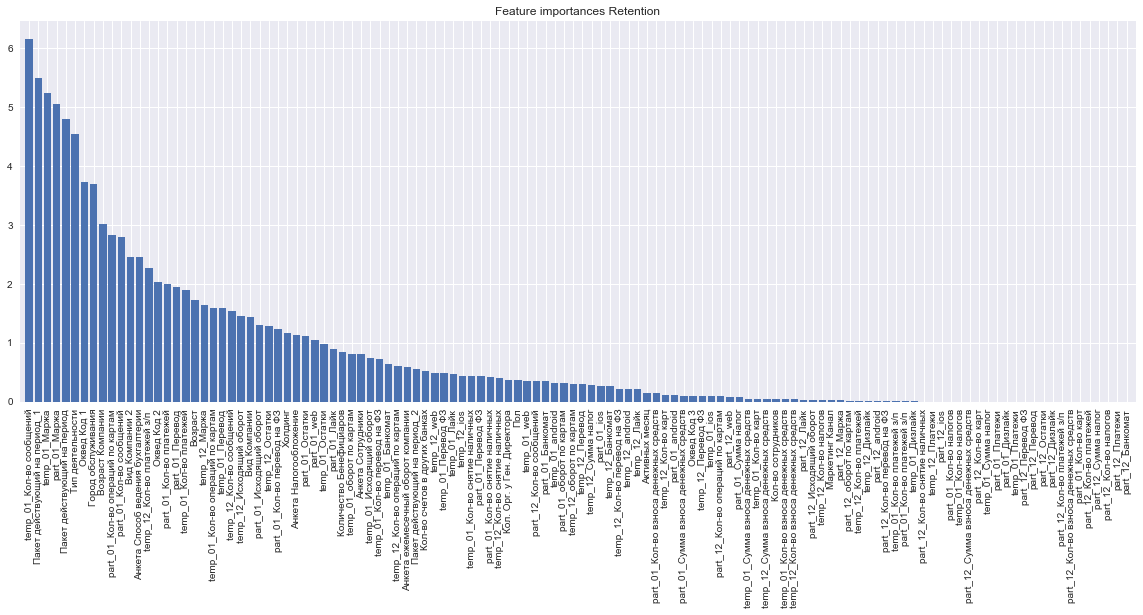

In [70]:
predictors = [x for x in X[train_col].columns]
#xgb =XGBClassifier(n_estimators=100, seed=42, n_jobs=16, #scale_pos_weight=sum(y==0) / sum(y==1),
                   #gpu_id=0)
#xgb.fit(x[train_col],y_h)
#print(model3_.feature_importances_)

importances = model3_.feature_importances_
indices = np.argsort(importances)[::-1]
d_first =X[train_col].shape[1]
xgb_col_h=X[train_col].columns[indices[:d_first]>0]
plt.figure(figsize=(20, 7))
plt.title("Feature importances Retention")
plt.bar(range(d_first), np.array(importances)[indices], align='center')
plt.xticks(range(d_first), np.array(X[train_col].columns)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first])

### Принцип ранжирования NEXT BEST OFFER
1. По модели предложения продукта CatBoost получаем вероятности взятия клиентом продукта
2. Умножаем вероятности продуктов на ср. время жизни продуктов у клиентов в банке
3. Умножаем полученное в п.2 значение на ср. стоимость продукта
4. По полученному индексу в п.1-п.3 ранжируем в рамках продукта пользователей и берем on-top N клиентов для предложения i-го продукта. 
    ИТОГО: RANK-i=(T-i) х (P-i) х (Profit-i)

__________________________


In [85]:
with open('model.pckl', 'wb') as f:
    pickle.dump(model3, f)

with open('model.pckl', 'rb') as f:
    mimi = pickle.load(f)

mimi.feature_importances_

In [86]:
model4 = CatBoostClassifier(iterations=500, 
                            learning_rate=0.1,
                            depth=7, 
                            loss_function='MultiClass',
                            eval_metric='TotalF1',
                            random_seed=42,
                            od_type='Iter',
                            thread_count=4,
                            od_wait=10) 
model3.fit(X.loc[train,:], y.loc[train], eval_set=(X.loc[valid,:], y.loc[valid]),
           use_best_model=True, verbose=True, cat_features=cf)

0:	learn: 0.6302825	test: 0.6256973	best: 0.6256973 (0)	total: 3.96s	remaining: 32m 58s
1:	learn: 0.6371869	test: 0.6360793	best: 0.6360793 (1)	total: 8.05s	remaining: 33m 25s
2:	learn: 0.6343229	test: 0.6333553	best: 0.6360793 (1)	total: 12.8s	remaining: 35m 18s
3:	learn: 0.6323018	test: 0.6317177	best: 0.6360793 (1)	total: 18s	remaining: 37m 17s
4:	learn: 0.6312637	test: 0.6303061	best: 0.6360793 (1)	total: 23.1s	remaining: 38m 10s
5:	learn: 0.6341295	test: 0.6338994	best: 0.6360793 (1)	total: 28.2s	remaining: 38m 40s
6:	learn: 0.6346373	test: 0.6333407	best: 0.6360793 (1)	total: 30.7s	remaining: 36m
7:	learn: 0.6350452	test: 0.6336606	best: 0.6360793 (1)	total: 35.4s	remaining: 36m 18s
8:	learn: 0.6347768	test: 0.6347174	best: 0.6360793 (1)	total: 40s	remaining: 36m 20s
9:	learn: 0.6380578	test: 0.6362459	best: 0.6362459 (9)	total: 44.9s	remaining: 36m 41s
10:	learn: 0.6394684	test: 0.6379173	best: 0.6379173 (10)	total: 49.5s	remaining: 36m 40s
11:	learn: 0.6413595	test: 0.6395515	b

91:	learn: 0.7174297	test: 0.7135046	best: 0.7135930 (90)	total: 8m 8s	remaining: 36m 8s
92:	learn: 0.7178534	test: 0.7138856	best: 0.7138856 (92)	total: 8m 14s	remaining: 36m 2s
93:	learn: 0.7180897	test: 0.7140000	best: 0.7140000 (93)	total: 8m 19s	remaining: 35m 58s
94:	learn: 0.7194151	test: 0.7151920	best: 0.7151920 (94)	total: 8m 25s	remaining: 35m 53s
95:	learn: 0.7203194	test: 0.7145399	best: 0.7151920 (94)	total: 8m 30s	remaining: 35m 49s
96:	learn: 0.7206893	test: 0.7154095	best: 0.7154095 (96)	total: 8m 35s	remaining: 35m 39s
97:	learn: 0.7212590	test: 0.7154217	best: 0.7154217 (97)	total: 8m 39s	remaining: 35m 32s
98:	learn: 0.7216721	test: 0.7162304	best: 0.7162304 (98)	total: 8m 44s	remaining: 35m 25s
99:	learn: 0.7220732	test: 0.7165295	best: 0.7165295 (99)	total: 8m 49s	remaining: 35m 17s
100:	learn: 0.7224099	test: 0.7166506	best: 0.7166506 (100)	total: 8m 53s	remaining: 35m 8s
101:	learn: 0.7229724	test: 0.7167195	best: 0.7167195 (101)	total: 8m 58s	remaining: 35m
102

180:	learn: 0.7520706	test: 0.7381685	best: 0.7381685 (180)	total: 15m 37s	remaining: 27m 33s
181:	learn: 0.7527336	test: 0.7396890	best: 0.7396890 (181)	total: 15m 43s	remaining: 27m 29s
182:	learn: 0.7534996	test: 0.7396311	best: 0.7396890 (181)	total: 15m 49s	remaining: 27m 24s
183:	learn: 0.7537535	test: 0.7388531	best: 0.7396890 (181)	total: 15m 54s	remaining: 27m 19s
184:	learn: 0.7541794	test: 0.7392192	best: 0.7396890 (181)	total: 15m 59s	remaining: 27m 14s
185:	learn: 0.7539512	test: 0.7396674	best: 0.7396890 (181)	total: 16m 4s	remaining: 27m 8s
186:	learn: 0.7541301	test: 0.7402110	best: 0.7402110 (186)	total: 16m 9s	remaining: 27m 2s
187:	learn: 0.7546833	test: 0.7402294	best: 0.7402294 (187)	total: 16m 13s	remaining: 26m 55s
188:	learn: 0.7547904	test: 0.7404995	best: 0.7404995 (188)	total: 16m 18s	remaining: 26m 50s
189:	learn: 0.7548634	test: 0.7404311	best: 0.7404995 (188)	total: 16m 24s	remaining: 26m 46s
190:	learn: 0.7549801	test: 0.7407171	best: 0.7407171 (190)	tota

In [ ]:
model5 = CatBoostClassifier(iterations=500, 
                            learning_rate=0.05,
                            depth=6, 
                            loss_function='MultiClass',
                            eval_metric='TotalF1',
                            random_seed=42,
                            od_type='Iter',
                            thread_count=4,
                            od_wait=10) 
model3.fit(X.loc[train,:], y.loc[train], eval_set=(X.loc[valid,:], y.loc[valid]),
           use_best_model=True, verbose=True, cat_features=cf)

_____________